In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, utils, Model, regularizers
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, 
    MaxPooling2D, Dropout, Dense, Add, GlobalAveragePooling2D, Flatten
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, classification_report
)

print("TensorFlow:", tf.__version__)
print("TFP:", tfp.__version__)



TensorFlow: 2.19.0
TFP: 0.25.0


In [42]:
# DANECHKA я ебал этот куда, просто комментируй этот блок
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Включаем оптимизации oneDNN (важно для Intel)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

# Для 12-го поколения особенно важно включить Intel DL Boost
os.environ['TF_ENABLE_MKL_NATIVE_FORMAT'] = '1'

def configure_cpu_optimization():
    physical_cores = os.cpu_count() // 2
    logical_cores = os.cpu_count()
    
    tf.config.threading.set_intra_op_parallelism_threads(logical_cores)
    tf.config.threading.set_inter_op_parallelism_threads(physical_cores)
    
    tf.config.optimizer.set_jit(True)
    tf.config.set_soft_device_placement(True)

    # itex.set_backend('cpu', throughput_mode=True)

configure_cpu_optimization()

In [44]:
# Путь к вашей папке с неразложенными файлами
# src_dir = r".\ieee-ai-and-ml-demystified\train\train"

# # Перебираем все файлы в папке
# for filename in os.listdir(src_dir):
#     if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # только изображения
#         continue
#     # Определяем класс по имени файла (до первой точки)
#     class_name = filename.split('.')[0]  # 'cat' или 'dog'
#     class_dir = os.path.join(src_dir, class_name)
#     # Создаём папку, если её нет
#     if not os.path.exists(class_dir):
#         os.makedirs(class_dir)
#     # Перемещаем файл
#     shutil.move(
#         os.path.join(src_dir, filename),
#         os.path.join(class_dir, filename)
#     )
# print("Готово! Все файлы разложены по папкам.")


In [48]:
# пайплайн
def build_data_pipeline(
    train_dir, 
    test_dir, 
    img_size=(32, 32), 
    batch_size=32, 
    val_split=0.2
):
    # Загрузка тренировочных и валидационных данных
    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=42,
        validation_split=val_split,
        subset='both'
    )
    
    # Загрузка тестовых данных
    test_ds = load_test_data(test_dir, img_size)
    
    # Нормализация данных
    rescale = layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (rescale(x), y), 
                          num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y), 
                      num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(lambda x, file_name: (rescale(x), file_name),
                        num_parallel_calls=tf.data.AUTOTUNE)
    
    # Оптимизация производительности
    train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

def load_test_data(test_dir, img_size):
    # Создаем датасет из файлов изображений
    file_paths = tf.data.Dataset.list_files(test_dir + "/*.jpg", shuffle=False)
    
    def process_file(file_path):
        # Загрузка и обработка изображения
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32)
        
        # Получаем имя файла для последующей идентификации
        file_name = tf.strings.split(file_path, os.sep)[-1]
        
        return img, file_name
    
    # Применяем функцию к каждому файлу
    test_ds = file_paths.map(process_file, num_parallel_calls=tf.data.AUTOTUNE)
    
    return test_ds

def visualize_dataset(dataset, title, show_filenames=False):
    plt.figure(figsize=(10, 10))
    for images, labels_or_filenames in dataset.take(1):
        for i in range(min(9, images.shape[0])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            
            if show_filenames:
                # Для тестового датасета показываем имена файлов
                plt.title(f"File: {labels_or_filenames[i].numpy().decode('utf-8')}")
            else:
                # Для train/val показываем метки
                plt.title(f"Label: {labels_or_filenames[i].numpy()}")
                
            plt.axis('off')
    plt.suptitle(title)
    plt.show()


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.

Структура датасетов:
Train: (TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
Val: (TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
Test: (TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))


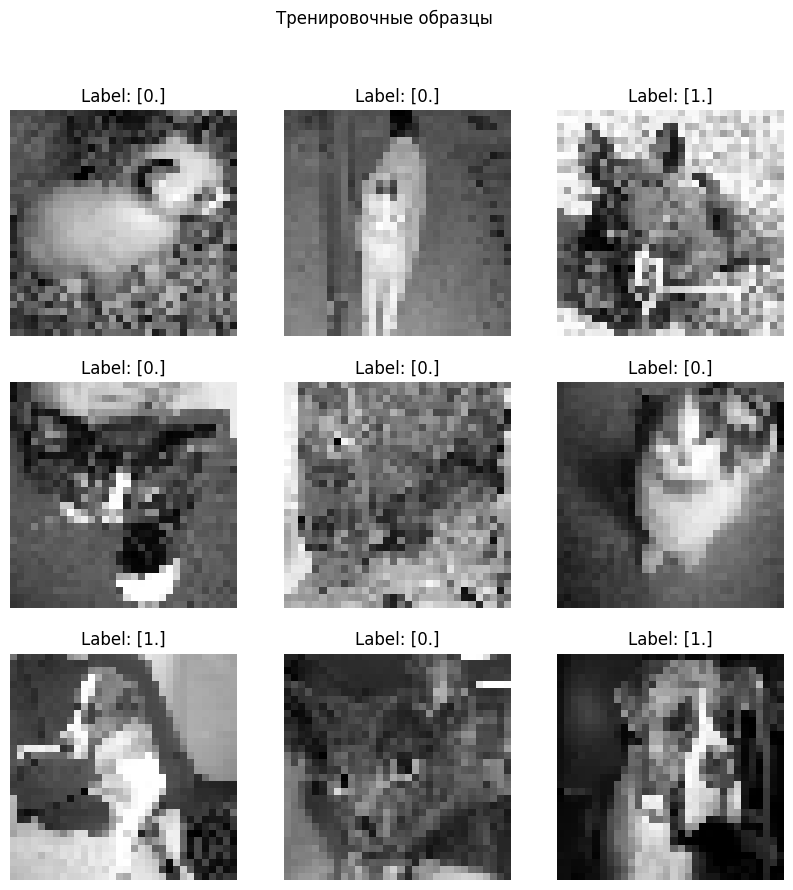

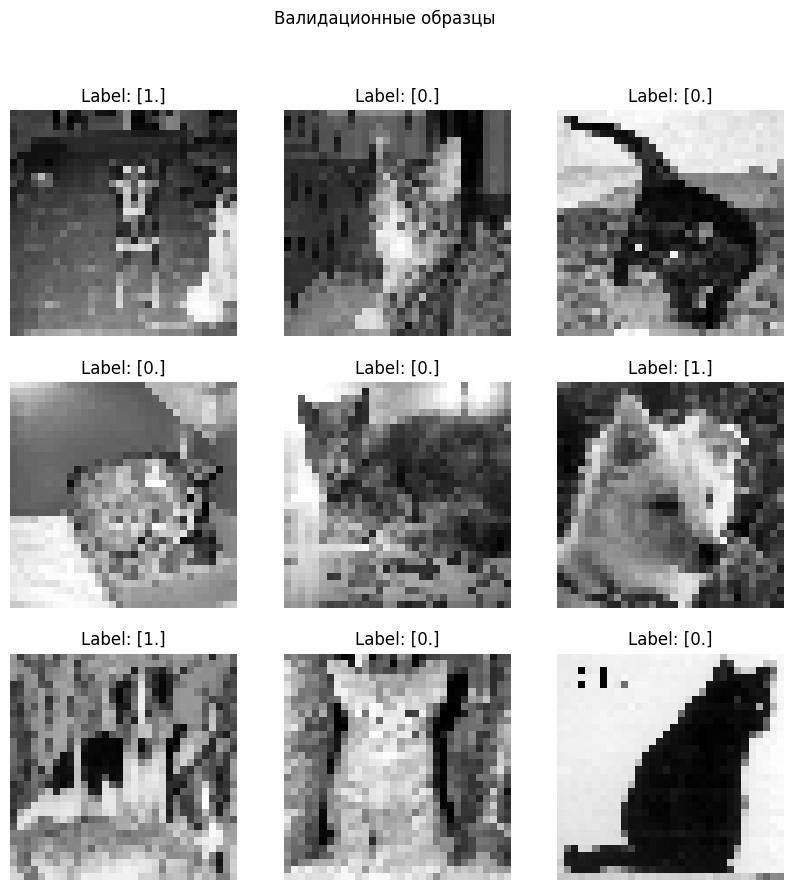

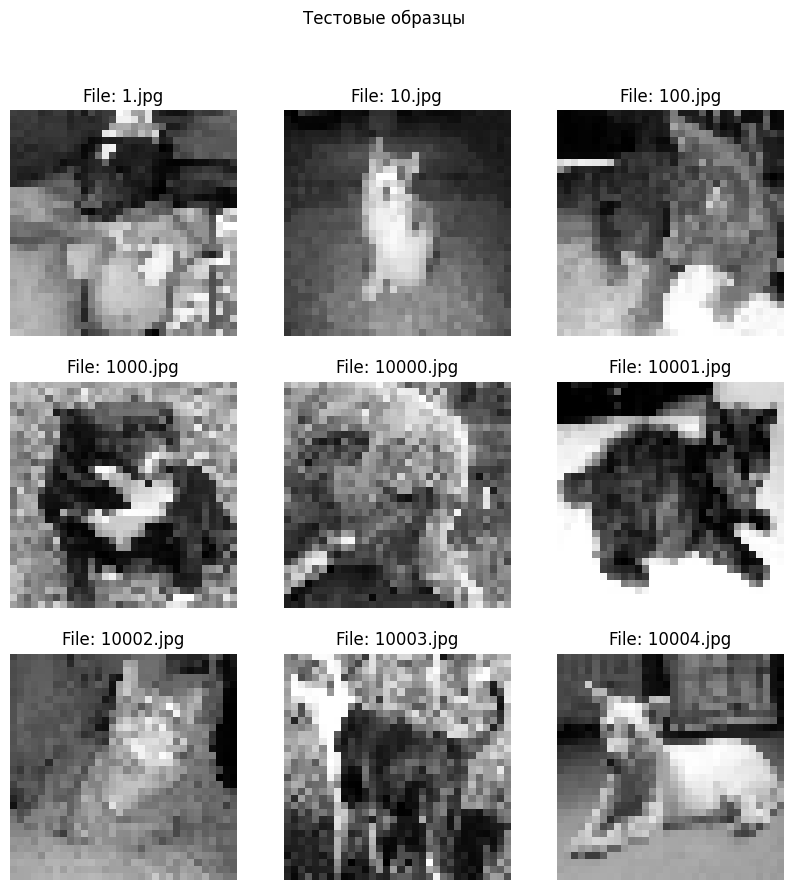

In [49]:
train_ds, val_ds, test_ds = build_data_pipeline(
    train_dir="./ieee-ai-and-ml-demystified/train/train",
    test_dir="./ieee-ai-and-ml-demystified/test1/test1",
    img_size=(32, 32),
    batch_size=32
)

# Проверка структуры данных
print("\nСтруктура датасетов:")
print(f"Train: {train_ds.element_spec}")
print(f"Val: {val_ds.element_spec}")
print(f"Test: {test_ds.element_spec}")

# Визуализация образцов из каждого датасета
visualize_dataset(train_ds, "Тренировочные образцы") 
visualize_dataset(val_ds, "Валидационные образцы")
visualize_dataset(test_ds, "Тестовые образцы", show_filenames=True)


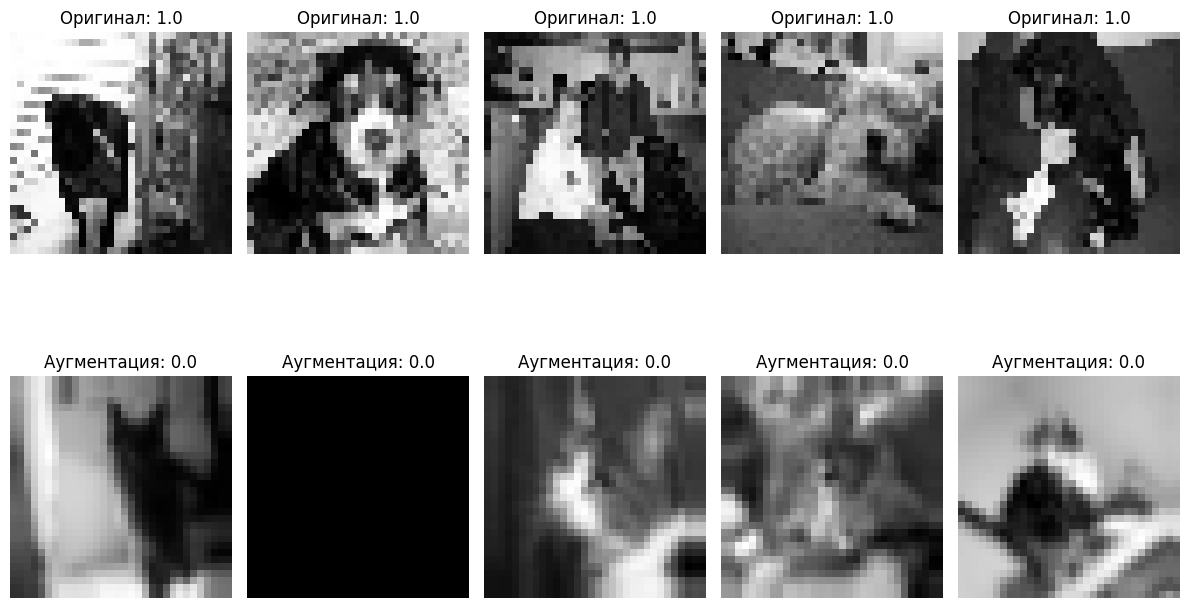

In [50]:
def add_advanced_augmentation(train_ds, val_ds, test_ds):
    # Создаем слои аугментации
    data_augmentation = tf.keras.Sequential([
        # Базовые преобразования (случайное отражение и поворот)
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        
        # Геометрические трансформации
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(0.1),
        
        # Изменения яркости и контраста
        layers.RandomBrightness(0.1),
        layers.RandomContrast(0.1),
    ])
    
    # Применяем аугментацию только к тренировочным данным
    augmented_train_ds = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return augmented_train_ds, val_ds, test_ds

# Применяем аугментацию к тренировочным данным
augmented_train_ds, val_ds, test_ds = add_advanced_augmentation(train_ds, val_ds, test_ds)

# Визуализируем оригинальные и аугментированные изображения
plt.figure(figsize=(12, 8))

# Получаем один батч из оригинального датасета
orig_images, orig_labels = next(iter(train_ds))

# Получаем один батч из аугментированного датасета
aug_images, aug_labels = next(iter(augmented_train_ds))

# Определяем количество изображений для отображения (не больше батча)
n = min(5, len(orig_images))

# Отображаем оригинальные изображения в верхнем ряду
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(orig_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Оригинал: {orig_labels[i].numpy()[0]}")
    plt.axis('off')

# Отображаем аугментированные изображения в нижнем ряду
for i in range(n):
    plt.subplot(2, n, n + i + 1)
    plt.imshow(aug_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Аугментация: {aug_labels[i].numpy()[0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



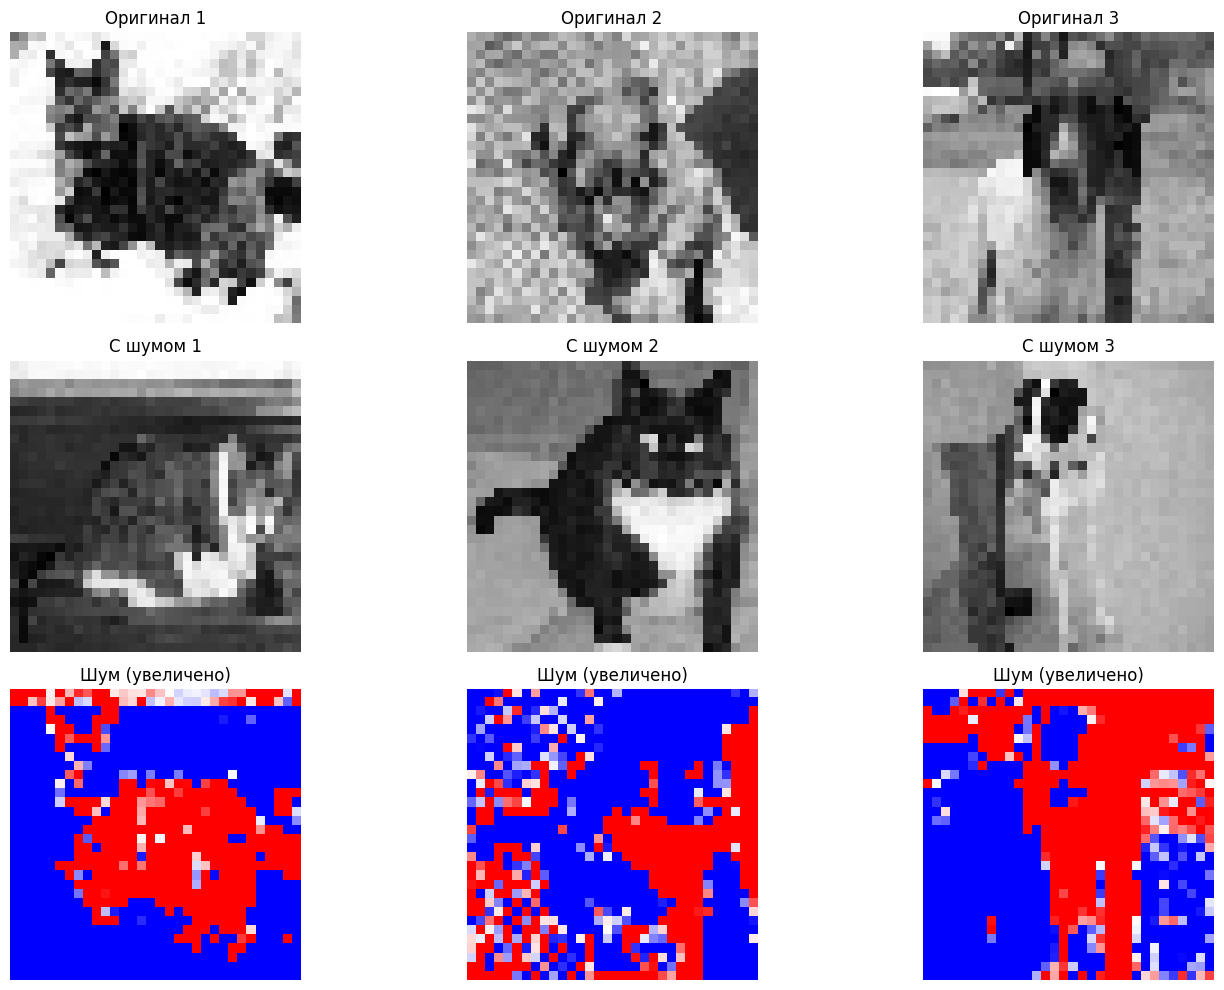

In [51]:
def add_gaussian_noise(image, mean=0.0, stddev=0.01):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=image.dtype)
    return image + noise

def apply_noise_regularization(train_ds, val_ds, test_ds):
    # Добавляем шум только к тренировочным данным
    noisy_train_ds = train_ds.map(
        lambda x, y: (add_gaussian_noise(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return noisy_train_ds, val_ds, test_ds

# Применяем шумовую регуляризацию к тренировочным данным
noisy_train_ds, val_ds, test_ds = apply_noise_regularization(train_ds, val_ds, test_ds)

# Визуализируем оригинальные и зашумленные изображения
plt.figure(figsize=(15, 10))

# Получаем один батч из оригинального датасета
orig_images, orig_labels = next(iter(train_ds))

# Получаем один батч из зашумленного датасета
noisy_images, noisy_labels = next(iter(noisy_train_ds))

# Определяем количество изображений для отображения
n = min(3, len(orig_images))

# Три ряда: оригинальные, зашумленные, и разница (шум)
for i in range(n):
    # Оригинальное изображение
    plt.subplot(3, n, i + 1)
    plt.imshow(orig_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Оригинал {i+1}")
    plt.axis('off')
    
    # Зашумленное изображение
    plt.subplot(3, n, n + i + 1)
    plt.imshow(noisy_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"С шумом {i+1}")
    plt.axis('off')
    
    # Визуализация самого шума (разницы)
    plt.subplot(3, n, 2*n + i + 1)
    diff = noisy_images[i].numpy().squeeze() - orig_images[i].numpy().squeeze()
    plt.imshow(diff, cmap='bwr', vmin=-0.05, vmax=0.05)
    plt.title(f"Шум (увеличено)")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [56]:
def analyze_class_distribution(train_ds):
    # Подсчитываем количество образцов каждого класса
    class_counts = {0: 0, 1: 0}
    
    for _, labels_batch in train_ds:
        # Обрабатываем весь батч сразу
        labels_np = labels_batch.numpy().flatten()  # Приводим к плоскому массиву
        for label in labels_np:
            label_int = int(label)
            if label_int in class_counts:
                class_counts[label_int] += 1
    
    total = sum(class_counts.values())
    print("Распределение классов:")
    for cls, count in class_counts.items():
        print(f"Класс {cls}: {count} образцов ({count/total:.2%})")
    
    # Вычисляем веса классов
    class_weights = {
        cls: total / (len(class_counts) * count) 
        for cls, count in class_counts.items()
    }
    
        # Построение графика распределения классов
    plt.figure(figsize=(6, 4))
    plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
    plt.xticks([0, 1], ['Класс 0', 'Класс 1'])
    plt.xlabel('Класс')
    plt.ylabel('Количество образцов')
    plt.title('Распределение классов в тренировочном наборе')
    plt.show()

    return class_weights



Распределение классов:
Класс 0: 10038 образцов (50.19%)
Класс 1: 9962 образцов (49.81%)


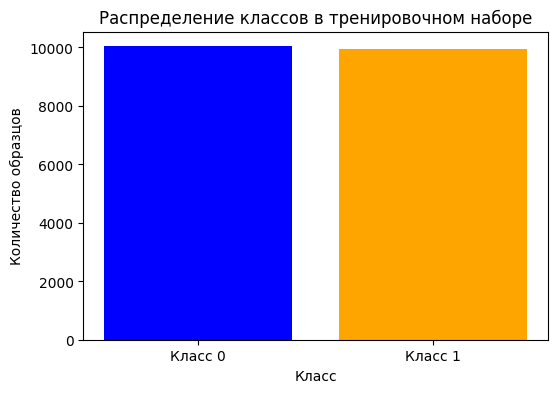

Epoch 1/100
218/625 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.5002 - loss: 2.0629 - precision: 0.4894 - recall: 0.5023

In [ ]:
# Определение residual блока (оставляем как есть)
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([shortcut, x])
    return Activation('relu')(x)

# Полная архитектура модели (оставляем как есть)
inputs = Input(shape=(32, 32, 1))
x = Conv2D(32, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Блок 1
x = residual_block(x, 32)
x = MaxPooling2D(2)(x)
x = Dropout(0.3)(x)

# Блок 2
x = residual_block(x, 64)  # Автоматическая проекция
x = MaxPooling2D(2)(x)
x = Dropout(0.4)(x)

# Блок 3
x = residual_block(x, 128)  # Автоматическая проекция
x = GlobalAveragePooling2D()(x)

# Полносвязные слои
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Scheduler обучения (оставляем как есть)
class SGDRScheduler(tf.keras.callbacks.Callback):
    def __init__(self, T_0=10, T_mult=2, eta_max=0.001, eta_min=1e-6):
        super().__init__()
        self.T_0 = T_0
        self.T_mult = T_mult
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.T_cur = 0
        self.T_i = T_0
        
    def on_epoch_begin(self, epoch, logs=None):
        self.T_cur += 1
        if self.T_cur >= self.T_i:
            self.T_cur = 0
            self.T_i *= self.T_mult
            
        lr = self.eta_min + 0.5*(self.eta_max - self.eta_min)*(1 + np.cos(np.pi*self.T_cur/self.T_i))
        self.model.optimizer.learning_rate.assign(lr)  # Исправлено здесь

# Подготовка улучшенных датасетов с аугментацией и шумом
# Используя функции, которые мы определили ранее
train_ds_augmented, val_ds, test_ds = add_advanced_augmentation(train_ds, val_ds, test_ds)
train_ds_final, val_ds, test_ds = apply_noise_regularization(train_ds_augmented, val_ds, test_ds)

# Преобразуем компоненты к согласованным размерностям
aligned_ds = train_ds_final.map(
    lambda x, y: (x, tf.reshape(y, [-1])),  # Преобразуем метки к форме [batch_size]
    num_parallel_calls=tf.data.AUTOTUNE
)

# Теперь можно безопасно использовать unbatch
class_weights = analyze_class_distribution(aligned_ds.unbatch())

# Компиляция модели
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Модифицированное обучение модели
history = model.fit(
    train_ds_final,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights,  # Добавляем веса классов
    callbacks=[
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        # Убираем ReduceLROnPlateau, так как у нас уже есть SGDRScheduler
        SGDRScheduler(T_0=10, T_mult=2)
    ],
    verbose=1
)

# Исправленная визуализация результатов
def plot_advanced_metrics(history):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1,3,1)
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='Train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Validation')
    plt.title('Эволюция функции потерь')
    
    plt.subplot(1,3,2)
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation')
    plt.title('Динамика точности')
    
    plt.subplot(1,3,3)
    # Исправляем построение precision-recall
    plt.plot(history.history['precision'], label='Precision')
    plt.plot(history.history['recall'], label='Recall')
    plt.legend()
    plt.title('Precision и Recall по эпохам')
    
    plt.tight_layout()
    plt.show()

    # Дополнительный график: Precision-Recall кривая
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['recall'], history.history['precision'])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall кривая')
    plt.grid(True)
    plt.show()

# Визуализация метрик
plot_advanced_metrics(history)

# Сохранение модели
model.save('cat_dog_classifier_pro.keras')
print("Модель успешно сохранена!")


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


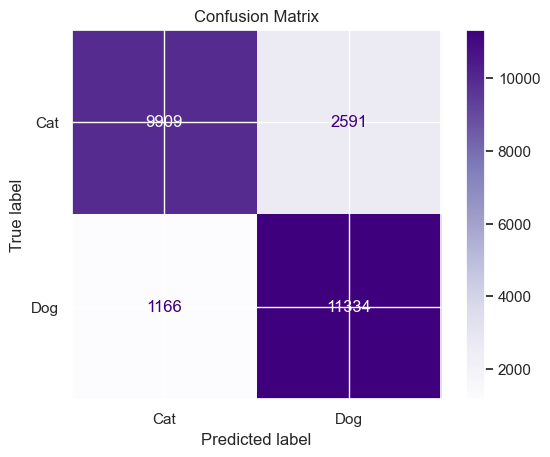

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


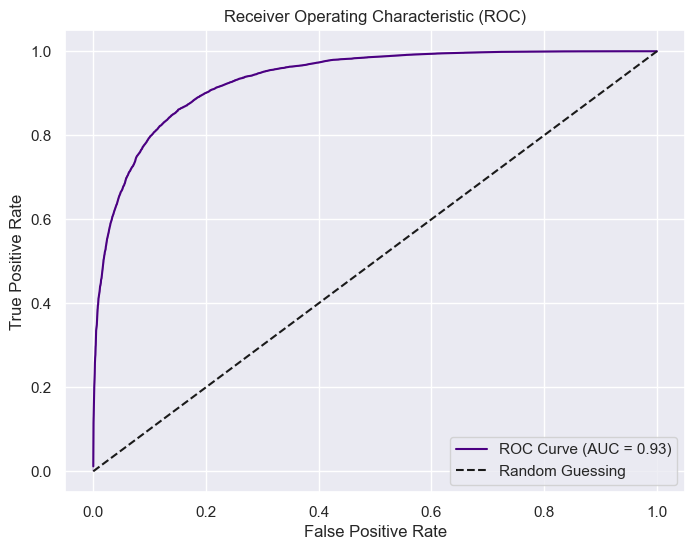

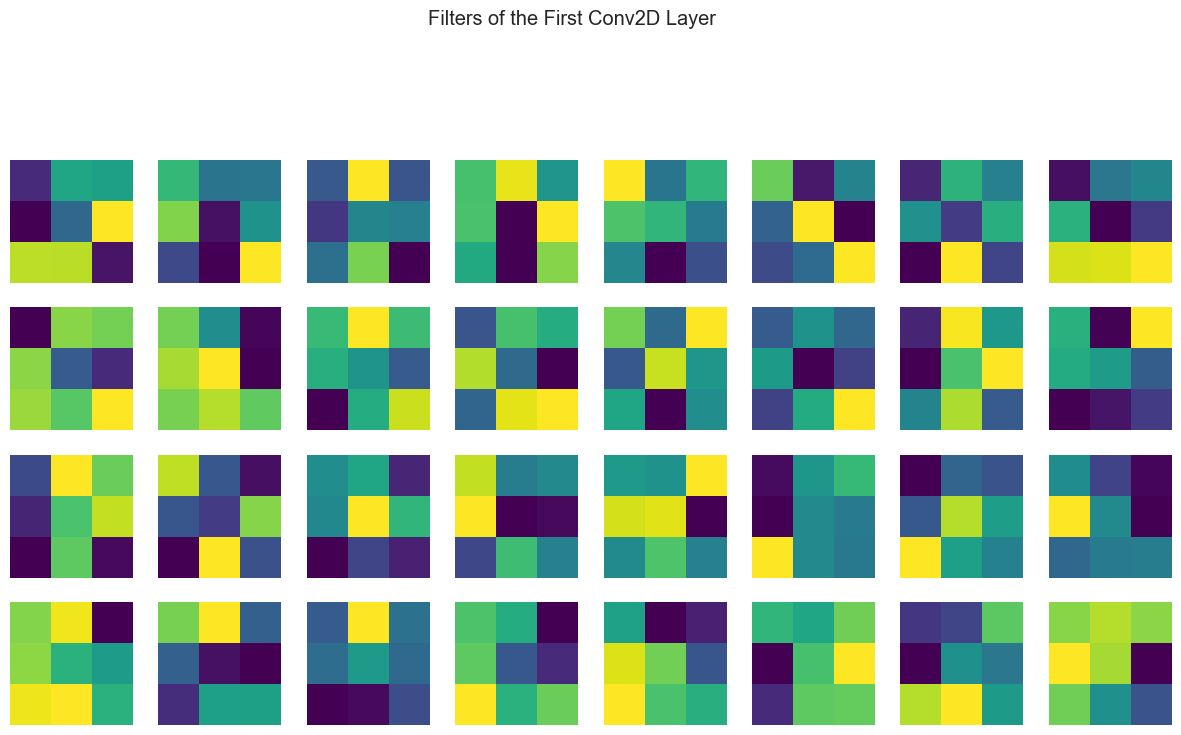

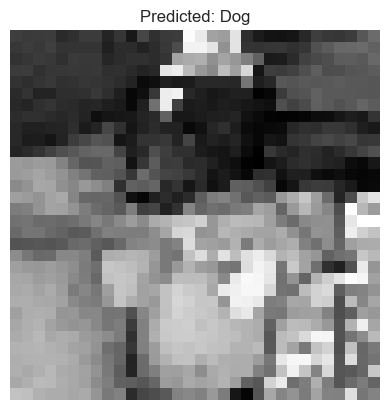

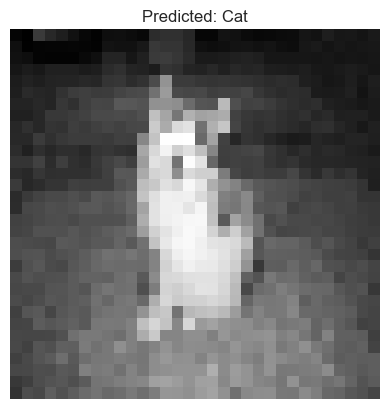

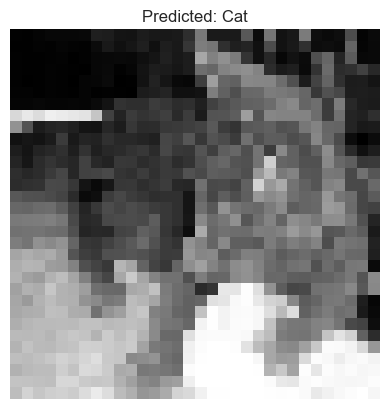

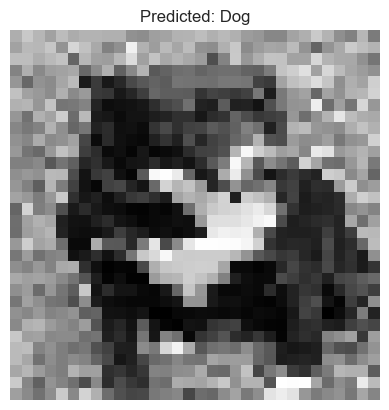

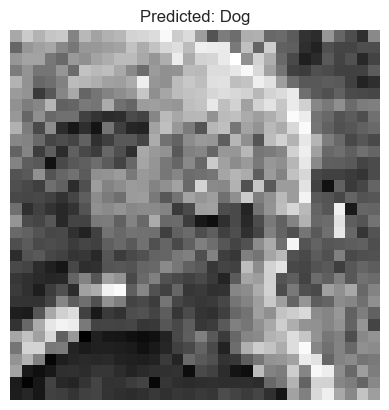

              precision    recall  f1-score   support

         Cat       0.89      0.79      0.84     12500
         Dog       0.81      0.91      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



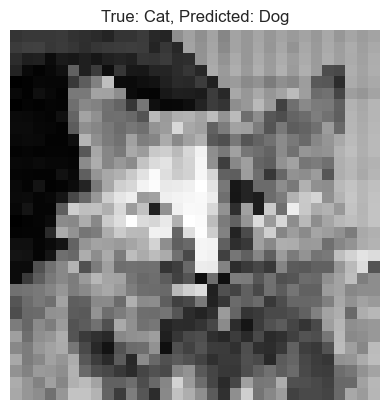

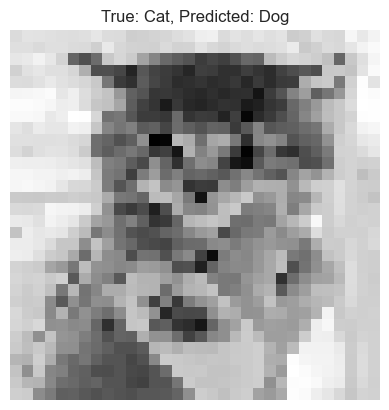

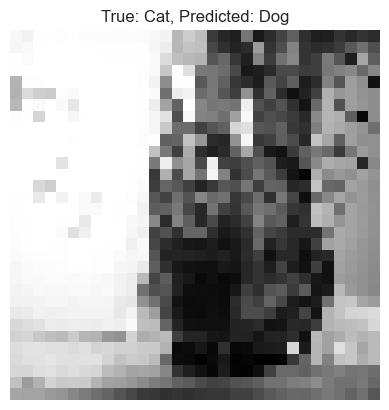

In [ ]:
# чтоб не ебаться
model_path = 'cat_dog_classifier_final.keras'
model = load_model(model_path)

X_test = []
id_line = []
def create_test1_data(path1):
    for p in os.listdir(path1):
        id_line.append(p.split(".")[0])
        img_array = cv2.imread(os.path.join(path1,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(32, 32))
        X_test.append(new_img_array)
        
create_test1_data(path_test)
X_test = np.array(X_test).reshape(-1,32,32,1)
X_test = X_test/255


predictions = model.predict(X_test)

predicted_val = [int(round(p[0])) for p in predictions] 

predicted_val[0:5]


submission_df = pd.DataFrame({'id':id_line, 'label':predicted_val}) 

submission_df.to_csv("submission123.csv", index=False)

# Пример: если у вас есть тестовые данные и предсказания
y_true = y  # Истинные метки (например, обучающие данные)
y_pred = (model.predict(X) > 0.5).astype("int32")  # Предсказания модели

# Построение матрицы ошибок
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap='Purples')
plt.title('Confusion Matrix')
plt.show()

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y, model.predict(X))
roc_auc = auc(fpr, tpr)

# Построение графика ROC-кривой для оценки качества бинарной классификации
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='indigo')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Визуализация фильтров первого сверточного слоя
filters, biases = model.layers[0].get_weights()
n_filters = filters.shape[-1]

plt.figure(figsize=(15, 15))
for i in range(n_filters):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters[:, :, 0, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Filters of the First Conv2D Layer')
plt.show()

# Визуализация предсказаний модели на тестовых данных
for i in range(5):
    plt.imshow(X_test[i].reshape(32, 32), cmap='gray')
    plt.title(f'Predicted: {"Dog" if predicted_val[i] == 1 else "Cat"}')
    plt.axis('off')
    plt.show()

# Расчёт точности для каждого класса (cat и dog)
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

# Примеры изображений на которых модель ошиблась
errors = np.where(y_true != y_pred.flatten())[0]

# Визуализация ошибок
for i in errors[:3]:  # Покажем первые 5 ошибок
    plt.imshow(X[i].reshape(32, 32), cmap='gray')
    plt.title(f'True: {"Dog" if y_true[i] == 1 else "Cat"}, Predicted: {"Dog" if y_pred[i] == 1 else "Cat"}')
    plt.axis('off')
    plt.show()
  

In [ ]:
def predict_image(image_path):
    # Загрузка изображения
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return "Ошибка загрузки изображения"
    
    # Предобработка
    resized_img = cv2.resize(img, (32, 32))
    normalized_img = resized_img / 255.0
    img_array = np.expand_dims(normalized_img, axis=[0, -1])
    
    # Предсказание
    prediction = model.predict(img_array)[0][0]
    result = "Собака" if prediction > 0.5 else "Кошка"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return f"Результат: {result} (уверенность: {confidence*100:.2f}%)"

# Создание Flask-приложения для интерфейса
from flask import Flask, request, render_template, jsonify
import io
from PIL import Image

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'Файл не найден'})
    
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'Файл не выбран'})
    
    # Чтение и обработка изображения
    in_memory_file = io.BytesIO()
    file.save(in_memory_file)
    image = np.array(Image.open(in_memory_file))
    
    # Преобразуем в оттенки серого если нужно
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # Изменяем размер до 32x32
    resized = cv2.resize(gray, (32, 32))
    # Нормализуем значения пикселей
    normalized = resized / 255.0
    # Преобразуем форму для модели
    processed_image = np.expand_dims(normalized, axis=[0, -1])
    
    # Получение предсказания
    prediction = model.predict(processed_image)[0][0]
    result = "Собака" if prediction > 0.5 else "Кошка"
    confidence = float(prediction) if prediction > 0.5 else float(1 - prediction)
    
    return jsonify({
        'result': result,
        'confidence': f"{confidence * 100:.2f}%"
    })

print("Чтобы запустить веб-интерфейс, выполните: app.run(debug=True)")

# Создаем HTML шаблон для веб-интерфейса
with open('./index.html', 'w') as f:
    f.write("""
<!DOCTYPE html>
<html>
<head>
    <title>Классификатор кошек и собак</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
        }
        .upload-form {
            border: 2px dashed #ccc;
            padding: 20px;
            text-align: center;
            margin-bottom: 20px;
        }
        #preview {
            max-width: 300px;
            margin: 20px auto;
        }
        .result {
            padding: 10px;
            border-radius: 5px;
            margin-top: 10px;
            text-align: center;
            font-weight: bold;
            font-size: 18px;
        }
    </style>
</head>
<body>
    <h1>Классификатор кошек и собак</h1>
    <div class="upload-form">
        <h2>Загрузите изображение</h2>
        <input type="file" id="imageInput" accept="image/*">
        <div id="preview"></div>
        <button id="predictBtn" disabled>Определить</button>
    </div>
    <div id="result" class="result"></div>

    <script>
        const imageInput = document.getElementById('imageInput');
        const previewDiv = document.getElementById('preview');
        const predictBtn = document.getElementById('predictBtn');
        const resultDiv = document.getElementById('result');

        imageInput.addEventListener('change', function() {
            const file = this.files[0];
            if (file) {
                const reader = new FileReader();
                reader.onload = function(e) {
                    previewDiv.innerHTML = `<img src="${e.target.result}" style="max-width: 100%;">`;
                    predictBtn.disabled = false;
                }
                reader.readAsDataURL(file);
            }
        });

        predictBtn.addEventListener('click', function() {
            const file = imageInput.files[0];
            if (!file) return;

            const formData = new FormData();
            formData.append('file', file);

            resultDiv.innerHTML = 'Обработка...';
            
            fetch('/predict', {
                method: 'POST',
                body: formData
            })
            .then(response => response.json())
            .then(data => {
                if (data.error) {
                    resultDiv.innerHTML = `Ошибка: ${data.error}`;
                } else {
                    resultDiv.innerHTML = `Результат: ${data.result} (уверенность: ${data.confidence})`;
                }
            })
            .catch(error => {
                resultDiv.innerHTML = `Ошибка: ${error.message}`;
            });
        });
    </script>
</body>
</html>
    """)

Чтобы запустить веб-интерфейс, выполните: app.run(debug=True)


FileNotFoundError: [Errno 2] No such file or directory: 'templates/index.html'